## Plant functional trait uncertainty outweighs climate change uncertainty in tundra ecosystems
#### This notebook accesses data from the Community Land Model as well as observational datasets from Niwot Ridge LTER (available on EDI) and plots results from simulations with hillslope hydrology as described in the manuscript 'Plant functional trait uncertainty outweighs climate change uncertainty in tundra ecosystems'

### Load packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
import functools

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# suppress Runtime warnings that let you know when code isn't running too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [4]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300041', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ext', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

/glade/work/jayka/opt/miniconda/envs/ctsm-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44911 instead
  f"Port {expected} is already in use.\n"


### Read in CLM model output

#### First point to files

In [6]:
# Niwot LTER  simulations - control, SSP370 runs
# H1 files dimensioned time x column or time x pft
path = '/glade/derecho/scratch/jayka/archive/' # path to files
path2 = '/glade/campaign/cgd/tss/people/wwieder/cheyenne_archive/archive/' # path to files from the default case
cases = ['NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans','NEON_NIWO_saddle_updated_SSP370','NEON_NIWO_saddle_updated_TraitExp1.1_SSP370','NEON_NIWO_saddle_updated_TraitExp1.3_SSP370',
         'NEON_NIWO_3col'] # case names

rollHour = -12  
years = range(2008,2022)
years2 = range(2087,2101)
years3 = range(2008,2020)

# create a list of the files we'll open for each case
finSaddle = [path + cases[0] +'/lnd/hist/'+cases[0]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSadAnom = [path + cases[1] +'/lnd/hist/'+cases[1]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt1 = [path + cases[2] +'/lnd/hist/'+cases[2]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt2 = [path + cases[3] +'/lnd/hist/'+cases[3]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finDefault = [path2 + cases[4] +'/lnd/hist/'+cases[4]+'.clm2.h1.'+str(years3[i]) +'-01-01-00000.nc' \
           for i in range(len(years3)) ]

# print the last year of data loaded
print(finSaddle[-1])

/glade/derecho/scratch/jayka/archive/NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans/lnd/hist/NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans.clm2.h1.2021-01-01-00000.nc


In [7]:
# Niwot LTER  simulations - control, SSP245 runs
# H1 files dimensioned time x column or time x pft
path = '/glade/derecho/scratch/jayka/archive/' # path to files
cases = ['NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans','NEON_NIWO_saddle_updated_SSP245','NEON_NIWO_saddle_updated_TraitExp1.1_SSP245','NEON_NIWO_saddle_updated_TraitExp1.3_SSP245'] # case names

rollHour = -12  
years = range(2008,2022)
years2 = range(2087,2101)

# create a list of the files we'll open for each case
finSaddle = [path + cases[0] +'/lnd/hist/'+cases[0]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSadAnomSSP = [path + cases[1] +'/lnd/hist/'+cases[1]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt1SSP = [path + cases[2] +'/lnd/hist/'+cases[2]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt2SSP = [path + cases[3] +'/lnd/hist/'+cases[3]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]

In [9]:
# combine transient and forced cases (loading in last 15 years only) - SSP370
fileSaddle = finSadAnom
fileTraitExpt1 = finTraitExpt1
fileTraitExpt2 = finTraitExpt2

In [11]:
# combine transient and forced cases (loading in last 15 years only) - SSP245
fileSaddle2 = finSadAnomSSP
fileSSP1 = finTraitExpt1SSP
fileSSP2 = finTraitExpt2SSP

#### Read in data with preprocessing

In [12]:
# define the history variables to read in
# SSP370
fields = ['AGNPP','AR','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSH','FSDS','GPP','H2OSOI','RAIN','SNOW','SNOW_DEPTH','TBOT','TSOI','QLATFLOWOUT','pft']
fields_default = ['AGNPP','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSH','GPP','pft']

def preprocess(ds, fields):
    '''Selects the variables we want to read in'''
    
    return ds[fields]

# open the datasets -- two for each case
dsSad = xr.open_mfdataset(finSaddle, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSadAnom = xr.open_mfdataset(fileSaddle, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsTraitExpt1 = xr.open_mfdataset(fileTraitExpt1, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsTraitExpt2 = xr.open_mfdataset(fileTraitExpt2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsDefault = xr.open_mfdataset(finDefault, decode_times=True,
                                 preprocess=functools.partial(preprocess, fields=fields_default))

print('-- your data have been read in -- ')

-- your data have been read in -- 


In [13]:
# define the history variables to read in
# SSP245
fields = ['AGNPP','AR','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSH','FSDS','GPP','H2OSOI','RAIN','SNOW','SNOW_DEPTH','TBOT','TSOI','QLATFLOWOUT','pft']
fields_default = ['AGNPP','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSH','GPP','pft']

def preprocess(ds, fields):
    '''Selects the variables we want to read in'''
    
    return ds[fields]

# open the datasets

dsSadAnomSSP = xr.open_mfdataset(fileSaddle2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSSP1 = xr.open_mfdataset(fileSSP1, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSSP2 = xr.open_mfdataset(fileSSP2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

print('-- your data have been read in -- ')

-- your data have been read in -- 


In [14]:
# Combine pft and column coordinates
dsSad = dsSad.rename({'pft':'column'})
dsSadAnom = dsSadAnom.rename({'pft':'column'})
dsTraitExpt1 = dsTraitExpt1.rename({'pft':'column'})
dsTraitExpt2 = dsTraitExpt2.rename({'pft':'column'})
dsDefault = dsDefault.rename({'pft':'column'})

In [15]:
# Combine pft and column coordinates
dsSadSSP = dsSadAnomSSP.rename({'pft':'column'})
dsSSP1 = dsSSP1.rename({'pft':'column'})
dsSSP2 = dsSSP2.rename({'pft':'column'})

In [16]:
# select the desired columns and rename them
dsSad = dsSad.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSadAnom = dsSadAnom.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsTraitExpt1 = dsTraitExpt1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsTraitExpt2 = dsTraitExpt2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsDefault = dsDefault.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})

In [17]:
# select the desired columns and rename them
dsSadSSP = dsSadSSP.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSSP1 = dsSSP1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSSP2 = dsSSP2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})

In [18]:
# Combine CLM datasets using 'sim' dimension to allow sorting and plotting by case
ds1 = xr.concat([dsSadAnom,dsTraitExpt1,dsTraitExpt2], 'sim', data_vars='all') # SSP370
ds1 = ds1.assign_coords(sim=("sim", ['Saddle','Expt1','Expt2']))

In [19]:
# Combine CLM datasets using 'sim' dimension to allow sorting and plotting by case
#ds2 = xr.concat([dsexpt1,dsexpt2,dsexpt3], 'sim', data_vars='all')
#ds2 = ds2.assign_coords(sim=("sim", ['control','acquis','cons']))

In [19]:
# Combine CLMdatasets using 'sim' dimension to allow sorting and plotting by case
ds3 = xr.concat([dsSadSSP,dsSSP1,dsSSP2], 'sim', data_vars='all') # SSP245
ds3 = ds3.assign_coords(sim=("sim", ['control','acquis','cons']))

In [20]:
# For saving figs
#out_dir = '/glade/u/home/jayka/NWT_CLM_plots/traits_figs/'

### Read in observations from the Saddle/Sensor network array to compare with CLM simulations (snow, soils, NPP, GCC)


In [22]:
nwtOBS = '/glade/work/jayka/inputdata/NWT_obs/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity
dsPHN = pd.read_table(nwtOBS+'saddle_sensntwk_phenocam_filtered.txt') # Saddle phenocam data
dsSNO_sens = pd.read_table(nwtOBS+'sensor_network_snow_data_30_min.txt') # sn array snow 

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
dsSNO_sens.date = pd.to_datetime(dsSNO_sens.date)
dsPHN.date = pd.to_datetime(dsPHN.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

/glade/work/jayka/opt/miniconda/envs/ctsm-py/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
# Aggregate data by date & vegetation community 
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup_sens = dsSNO_sens.groupby(['date','veg_com'])
dsSNOdaily_sens = dsSNOgroup_sens.aggregate(np.mean)

dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

dsPHNgroup = dsPHN.groupby(['date','veg_com'])
dsPHNdaily = dsPHNgroup.aggregate(np.mean)

In [24]:
# Convert Saddle and Sensor Network data to xarray
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsSNO_sens = dsSNOdaily_sens.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()
dsPHN = dsPHNdaily.to_xarray()

# reindex by veg community for plotting consistency
#Veg = ["DM", "MM","WM"]
Veg = ["WM","DM", "MM"]
fullVeg = ["wet_meadow","dry_meadow", "moist_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsSNO_sens = dsSNO_sens.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

# reindex CLM dataset by veg community
veg  = ["wm","dm","mm"]
ds1 = ds1.reindex({'column': veg})

In [25]:
# Convert Saddle and Sensor Network data to xarray
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsSNO_sens = dsSNOdaily_sens.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()
dsPHN = dsPHNdaily.to_xarray()

# reindex by veg community for plotting consistency
#Veg = ["DM", "MM","WM"]
Veg = ["MM","WM", "DM"]
fullVeg = ["moist_meadow","wet_meadow", "dry_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsSNO_sens = dsSNO_sens.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

# reindex CLM dataset by veg community
veg  = ["mm","wm","dm"]
ds1 = ds1.reindex({'column': veg})
ds3 = ds3.reindex({'column': veg})
dsSad = dsSad.reindex({'column': veg})

In [26]:
# reindex default CLM dataset by veg community
veg  = ["mm","wm","dm"]
dsDefault = dsDefault.reindex({'column': veg})

### Reading in Tvan flux tower data to compare with simulated fluxes

In [27]:
longSite  =  'dry_meadow'
years = range(2008,2022)
nmon  = 12
OBSdir = '/glade/work/jayka/inputdata/single_point/datm_NWT_Tvan/'+longSite+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')

In [28]:
# Now remove extra dimensions & coordinates
dsOBS  = dsOBS.isel(lat=0, lon=0)

# Remove CLM time shift
dsSad = dsSad.shift(time=-1)

In [29]:
# Calculate Rnet from absorbed - reflected radiation
dsSad['Rnet'] = dsSad.FSA - dsSad.FIRA	
dsSad['Rnet'].attrs['units'] = dsSad.FSA.attrs['units']
dsSad['Rnet'].attrs['long_name'] = 'net radiation'

dsDefault['Rnet'] = dsDefault.FSA - dsDefault.FIRA	
dsDefault['Rnet'].attrs['units'] = dsDefault.FSA.attrs['units']
dsDefault['Rnet'].attrs['long_name'] = 'net radiation'

In [30]:
# Calculate latent heat flux
dsSad['EFLX_LH_TOT'] = dsSad.FCEV + dsSad.FCTR + dsSad.FGEV
dsDefault['EFLX_LH_TOT'] = dsDefault.FCEV + dsDefault.FCTR + dsDefault.FGEV

In [31]:
# Convert observed GPP units from umol/m2/s to g/m2/d
# Assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600 * 24
dsOBS['GPP'].attrs['units'] = 'gC/m2/d'

# Now convert CLM GPP units from g/m2/s to g/m2/d
dsSad['GPP'] = dsSad.GPP * 3600 * 24
dsSad['GPP'].attrs['units'] = 'gC/m2/d'

# Now convert CLM GPP units from g/m2/s to g/m2/d
dsDefault['GPP'] = dsDefault.GPP * 3600 * 24
dsDefault['GPP'].attrs['units'] = 'gC/m2/d'

In [32]:
# Create new variables to subset by season
dsOBS['season'] = dsOBS['time.season']
dsSad['season'] = dsSad['time.season']
dsDefault['season'] = dsDefault['time.season']

Var = ['Rnet', 'FSH', 'EFLX_LH_TOT', 'GPP']
Season = ['DJF','MAM','JJA','SON']

In [33]:
# Can't groupby hour & minutes, so first combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
dsSad['HourMin'] = np.round(dsSad['time.hour'] + dsSad['time.minute']/60,1)
dsDefault['HourMin'] = np.round(dsDefault['time.hour'] + dsDefault['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
dsSad['MonDay'] = np.round(dsSad['time.month'] + dsSad['time.day']/100,2)
dsDefault['MonDay'] = np.round(dsDefault['time.month'] + dsDefault['time.day']/100,2)

### Model evaluation figures
#### Comparing productivity metrics between default simulation and NWT-specific parameterization (Figure 4)

In [30]:
# strings for labeling panels
panel = ['(a)','(b)'] 

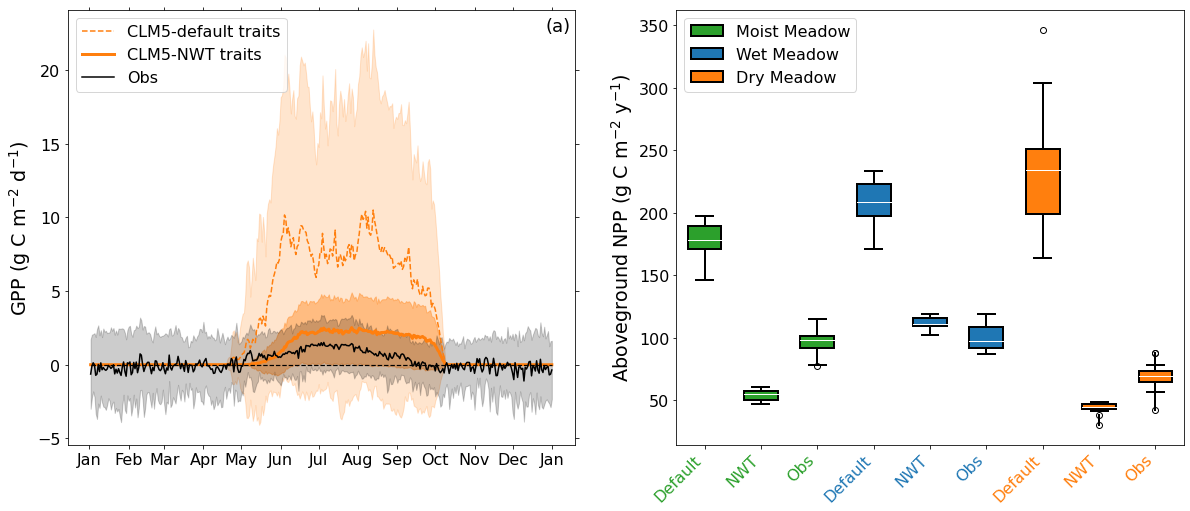

In [37]:
# both plots on the same fig

months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False,
                        figsize=(20,8))

# 1st panel - GPP
x = dsSad['time.dayofyear'].groupby(dsSad.MonDay).min()
x1 = dsOBS.GPP.where(dsOBS.GPP['time.year']<2020)
obsX = x1.groupby(dsOBS.MonDay).mean()
x2 = dsSad.GPP.where(dsSad.GPP['time.year']<2020)
clmX = x2.groupby(dsSad.MonDay).mean()
clm2X = dsDefault.GPP.groupby(dsDefault.MonDay).mean()
obsSD = x1.groupby(dsOBS.MonDay).std()
clmSD = x2.groupby(dsSad.MonDay).std()
clm2SD = dsDefault.GPP.groupby(dsDefault.MonDay).std()
 
ax1.plot(x, clm2X[:,2], '--',color='tab:orange', label='CLM5-default traits')
ax1.fill_between(x, clm2X[:,2] - clm2SD[:,2], clm2X[:,2] + clm2SD[:,2], alpha=0.2,color='tab:orange')
ax1.plot(x, clmX[:,2], '-', color='tab:orange', label='CLM5-NWT traits', linewidth=3)
ax1.fill_between(x, clmX[:,2] - clmSD[:,2], clmX[:,2] + clmSD[:,2], alpha=0.4,color='tab:orange')
ax1.plot(x, obsX, '-', color='k', label='Obs')
ax1.fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax1.set_ylabel("GPP (g C $\mathregular{m^{-2}}$ $\mathregular{d^{-1}}$)", fontsize='large')       
ax1.plot(x, np.zeros(365), '--', linewidth=1.2, color='k') # dashed line at zero
ax1.yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
ax1.xaxis.set_ticks_position('both')
ax1.legend(loc='upper left')

# set  x axis limits
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(months_fmt)

ax1.annotate(panel[0], xy=(370, 23), 
                ha='center', va='center',fontsize=18)  

# 2nd panel - aNPP
annNPP1 = dsDefault['AGNPP'].groupby(dsDefault['time.year']).mean()*3600*24*365
annNPP2 = dsSad['AGNPP'].groupby(dsSad['time.year']).mean()*3600*24*365
obsNPP = dsNPP.where(dsNPP['year']>2007).NPP/2 # select years 2008-2020 and divide by 2 to conver to gC/m2 from gDW
mask = ~np.isnan(obsNPP) # find the nans - boxplot doesn't allow them
obsNPP_filtered = [d[m] for d, m in zip(obsNPP.T, mask.T)] # remove the nans

# Define positions along the x-axis for each box
positions1 = [1, 4, 7]  # Positions for CLM5–default traits
positions2 = [2, 5, 8]  # Positions for CLM5–NWT traits
positions3 = [3, 6, 9]  # Positions for Obs

box_width=0.6 # adjust for wider boxes

# Define x-axis labels for each box position
x_labels = ['Default', 'NWT', 'Obs',
            'Default', 'NWT', 'Obs',
            'Default', 'NWT', 'Obs',]

# Plot boxplots at specified positions
box1 = ax2.boxplot(annNPP1, positions=positions1, patch_artist=True, widths=box_width, boxprops=dict(linestyle='-', linewidth=2),
                   medianprops=dict(color='white'), whiskerprops=dict(linestyle='-', linewidth=2),
                   capprops=dict(linestyle='-', linewidth=2), flierprops=dict(linestyle='-', linewidth=2))
box2 = ax2.boxplot(annNPP2, positions=positions2, patch_artist=True, widths=box_width, boxprops=dict(linestyle='-', linewidth=2),
                   medianprops=dict(color='white'), whiskerprops=dict(linestyle='-', linewidth=2),
                   capprops=dict(linestyle='-', linewidth=2), flierprops=dict(linestyle='-', linewidth=2))
box3 = ax2.boxplot(obsNPP_filtered, positions=positions3, patch_artist=True, widths=box_width, boxprops=dict(linestyle='-', linewidth=2),
                   medianprops=dict(color='white'), whiskerprops=dict(linestyle='-', linewidth=2), capprops=dict(linestyle='-', linewidth=2), flierprops=dict(linestyle='-', linewidth=2))

# Set custom x-axis labels and ticks
ax2.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax2.set_xticklabels(x_labels, rotation=45, ha='right')

# Define colors for each community
label_colors = ['tab:green','tab:green','tab:green', 'tab:blue','tab:blue','tab:blue', 'tab:orange','tab:orange','tab:orange']

# Apply colors to each label
for tick, color in zip(ax2.get_xticklabels(), label_colors):
    tick.set_color(color)

# Set y-axis label
ax2.set_ylabel("Aboveground NPP (g C $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$)", fontsize='large')

# change colors by community
colors = ['tab:green', 'tab:blue', 'tab:orange']
for bplot in (box1):
    for patch, color in zip(box1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linestyle('solid')
for bplot in (box2):
    for patch, color in zip(box2['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')
for bplot in (box3):
    for patch, color in zip(box3['boxes'], colors):
        patch.set_facecolor(color)     
        patch.set_linestyle('solid')
        
ax2.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0]], ['Moist Meadow', 'Wet Meadow', 'Dry Meadow'], loc='upper left')
leg = ax2.get_legend()
#leg.legendHandles[0].set_facecolor('white')
leg.legendHandles[1].set_facecolor('tab:blue')
leg.legendHandles[2].set_facecolor('tab:orange')

#plt.savefig(out_dir+'Fig3_GPP_ANPP_v2.pdf', bbox_inches='tight');

#### Climatologies of snowdepth, GPP, and GCC (green chromatic coordinate) (Figure 4)

In [34]:
# increase font size in plots
plt.rcParams.update({'font.size': 16})

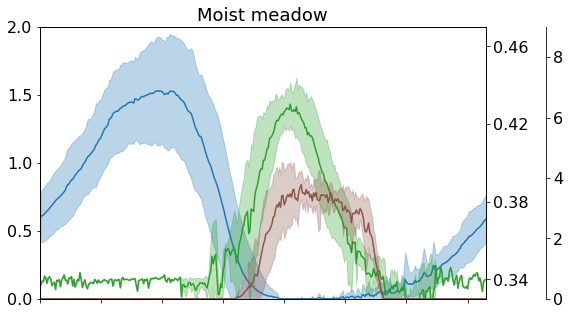

In [34]:
GPP = dsSad.GPP
GPP = GPP.resample(time='D').mean('time')

y1 = dsPHN.gcc.groupby("date.dayofyear").mean('date')
ySD = dsPHN.gcc.groupby("date.dayofyear").std('date')
x1 = GPP.groupby("time.dayofyear").mean('time')
xSD = GPP.groupby("time.dayofyear").std('time')
x2 = dsSad.SNOW_DEPTH.groupby("time.dayofyear").mean('time')
x2SD = dsSad.SNOW_DEPTH.groupby("time.dayofyear").std('time')

fig, host = plt.subplots(figsize=(8,5)) 

par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 365)
host.set_ylim(0, 2)
par1.set_ylim(0.33, 0.47)
par2.set_ylim(0, 9)

p1, = host.plot(x2['dayofyear'], x2.sel(column='mm'),  color="tab:blue", label="Snow depth");
p2, = par1.plot(y1['dayofyear'], y1.sel(veg_com='MM'),  color="tab:green", label="GCC");
p3, = par2.plot(x1['dayofyear'], x1.sel(column='mm'), color="tab:brown", label="GPP");

p1 = host.fill_between(x2['dayofyear'], x2.sel(column='mm') - x2SD.sel(column='mm'), x2.sel(column='mm') + x2SD.sel(column='mm'), color = "tab:blue", alpha=0.3);
p2 = par1.fill_between(y1['dayofyear'], y1.sel(veg_com='MM') - ySD.sel(veg_com='MM'), y1.sel(veg_com='MM') + ySD.sel(veg_com='MM'), color = "tab:green", alpha=0.3);
p3 = par2.fill_between(x1['dayofyear'], x1.sel(column='mm') - xSD.sel(column='mm'), x1.sel(column='mm') + xSD.sel(column='mm'), color = "tab:brown", alpha=0.3);

host.set_yticks([0, 0.5, 1, 1.5, 2]);
par1.set_yticks([0.34, 0.38, 0.42, 0.46]);
par2.set_yticks([0, 2, 4, 6, 8]);

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.set_xticklabels([])

host.set_title("Moist meadow", fontsize=18);
    
#host.set_xlabel("Day of year",fontsize=14)
#host.set_ylabel("Snow depth",fontsize=14)
#par1.set_ylabel("GCC",fontsize=14)
#par2.set_ylabel("GPP",fontsize=14)

#host.yaxis.label.set_color('tab:blue')
#par1.yaxis.label.set_color('tab:green')
#par2.yaxis.label.set_color('tab:brown')\

#plt.savefig(out_dir+'Fig4_MM.pdf', bbox_inches='tight');

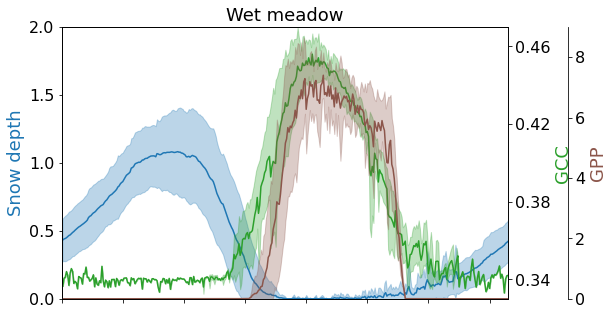

In [31]:
GPP = dsSad.GPP
GPP = GPP.resample(time='D').mean('time')

y1 = dsPHN.gcc.groupby("date.dayofyear").mean('date')
ySD = dsPHN.gcc.groupby("date.dayofyear").std('date')
x1 = GPP.groupby("time.dayofyear").mean('time')
xSD = GPP.groupby("time.dayofyear").std('time')
x2 = dsSad.SNOW_DEPTH.groupby("time.dayofyear").mean('time')
x2SD = dsSad.SNOW_DEPTH.groupby("time.dayofyear").std('time')

fig, host = plt.subplots(figsize=(8,5)) 

par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 365)
host.set_ylim(0, 2)
par1.set_ylim(0.33, 0.47)
par2.set_ylim(0, 9)
    
p1, = host.plot(x2['dayofyear'], x2.sel(column='wm'),  color="tab:blue", label="Snow depth")
p2, = par1.plot(y1['dayofyear'], y1.sel(veg_com='WM'),  color="tab:green", label="GCC")
p3, = par2.plot(x1['dayofyear'], x1.sel(column='wm'), color="tab:brown", label="GPP")

p1 = host.fill_between(x2['dayofyear'], x2.sel(column='wm') - x2SD.sel(column='wm'), x2.sel(column='wm') + x2SD.sel(column='wm'), color = "tab:blue", alpha=0.3)
p2 = par1.fill_between(y1['dayofyear'], y1.sel(veg_com='WM') - ySD.sel(veg_com='WM'), y1.sel(veg_com='WM') + ySD.sel(veg_com='WM'), color = "tab:green", alpha=0.3)
p3 = par2.fill_between(x1['dayofyear'], x1.sel(column='wm') - xSD.sel(column='wm'), x1.sel(column='wm') + xSD.sel(column='wm'), color = "tab:brown", alpha=0.3)

host.set_yticks([0, 0.5, 1, 1.5, 2]);
par1.set_yticks([0.34, 0.38, 0.42, 0.46]);
par2.set_yticks([0, 2, 4, 6, 8]);

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.set_xticklabels([])

#host.set_xlabel("Day of year",fontsize=14)
host.set_ylabel("Snow depth",fontsize=18)
par1.set_ylabel("GCC",fontsize=18)
par2.set_ylabel("GPP",fontsize=18)
host.set_title("Wet meadow", fontsize=18)

host.yaxis.label.set_color('tab:blue')
par1.yaxis.label.set_color('tab:green')
par2.yaxis.label.set_color('tab:brown')

#plt.savefig(out_dir+'Fig4_WM.pdf', bbox_inches='tight')

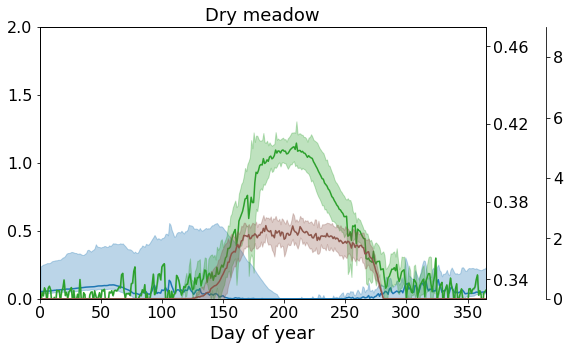

In [33]:
GPP = dsSad.GPP
GPP = GPP.resample(time='D').mean('time')

y1 = dsPHN.gcc.groupby("date.dayofyear").mean('date')
ySD = dsPHN.gcc.groupby("date.dayofyear").std('date')
x1 = GPP.groupby("time.dayofyear").mean('time')
xSD = GPP.groupby("time.dayofyear").std('time')
x2 = dsSad.SNOW_DEPTH.groupby("time.dayofyear").mean('time')
x2SD = dsSad.SNOW_DEPTH.groupby("time.dayofyear").std('time')

fig, host = plt.subplots(figsize=(8,5)) 

par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 365)
host.set_ylim(0, 2)
par1.set_ylim(0.33, 0.47)
par2.set_ylim(0, 9)

p1, = host.plot(x2['dayofyear'], x2.sel(column='dm'),  color="tab:blue", label="Snow depth")
p2, = par1.plot(y1['dayofyear'], y1.sel(veg_com='DM'),  color="tab:green", label="GCC")
p3, = par2.plot(x1['dayofyear'], x1.sel(column='dm'), color="tab:brown", label="GPP")

p1 = host.fill_between(x2['dayofyear'], x2.sel(column='dm') - x2SD.sel(column='dm'), x2.sel(column='dm') + x2SD.sel(column='mm'), color = "tab:blue", alpha=0.3)
p2 = par1.fill_between(y1['dayofyear'], y1.sel(veg_com='DM') - ySD.sel(veg_com='DM'), y1.sel(veg_com='DM') + ySD.sel(veg_com='DM'), color = "tab:green", alpha=0.3)
p3 = par2.fill_between(x1['dayofyear'], x1.sel(column='dm') - xSD.sel(column='dm'), x1.sel(column='dm') + xSD.sel(column='dm'), color = "tab:brown", alpha=0.3)

host.set_yticks([0, 0.5, 1, 1.5, 2]);
par1.set_yticks([0.34, 0.38, 0.42, 0.46]);
par2.set_yticks([0, 2, 4, 6, 8]);

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))
    
host.set_xlabel("Day of year",fontsize=18);
#host.set_ylabel("Snow depth",fontsize=14)
#par1.set_ylabel("GCC",fontsize=14)
#par2.set_ylabel("GPP",fontsize=14)
host.set_title("Dry meadow", fontsize=18);

#host.yaxis.label.set_color('tab:blue')
#par1.yaxis.label.set_color('tab:green')
#par2.yaxis.label.set_color('tab:brown')

#plt.savefig(out_dir+'Fig4_DM.pdf', bbox_inches='tight');

### Model projection figures
#### Comparing GPP between trait experiments for historical and future scenarios (Figure 5)

In [35]:
# First convert CLM GPP units from g/m2/s to g/m2/d
ds1['GPP'] = ds1.GPP * 3600 * 24
ds1['GPP'].attrs['units'] = 'gC/m2/y'

In [36]:
# First convert CLM GPP units from g/m2/s to g/m2/d
ds3['GPP'] = ds3.GPP * 3600 * 24
ds3['GPP'].attrs['units'] = 'gC/m2/y'

In [37]:
plt.rcParams.update({'font.size': 20})

In [38]:
# strings for labeling panels
panel = ['(a)','(b)','(c)'] 

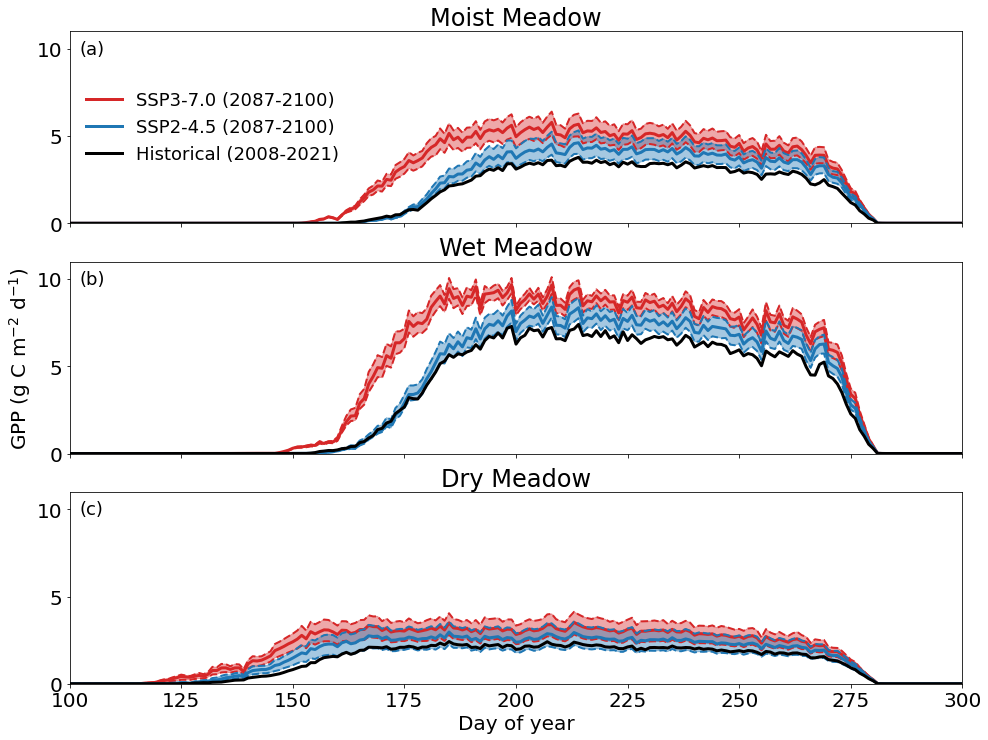

In [40]:
veglist = ['Moist Meadow','Wet Meadow','Dry Meadow']

x1 = ds1.GPP.sel(sim='Saddle').groupby("time.dayofyear").mean('time')
x2 = ds1.GPP.sel(sim='Expt1').groupby("time.dayofyear").mean('time')
x3 = ds1.GPP.sel(sim='Expt2').groupby("time.dayofyear").mean('time')
x4 = ds3.GPP.sel(sim='control').groupby("time.dayofyear").mean('time')
x5 = ds3.GPP.sel(sim='acquis').groupby("time.dayofyear").mean('time')
x6 = ds3.GPP.sel(sim='cons').groupby("time.dayofyear").mean('time')
x7 = dsSad.GPP.groupby("time.dayofyear").mean('time')

fig, axs = plt.subplots(3, 1,  gridspec_kw={'wspace': 0.3, 'hspace': 0.2}, figsize=(16,12))

for i in range(len(ds1.column)):
    y1 =  x1.isel(column=i)
    y2 =  x2.isel(column=i)
    y3 =  x3.isel(column=i) 
    y4 =  x4.isel(column=i)
    y5 =  x5.isel(column=i)
    y6 =  x6.isel(column=i)
    y7 =  x7.isel(column=i)

    axs[i].plot(x1['dayofyear'], y1, label='SSP3-7.0 (2087-2100)', linewidth=3, color='tab:red') ;
    axs[i].plot(x2['dayofyear'], y2, '--', linewidth=2, color='tab:red') ;
    axs[i].plot(x3['dayofyear'], y3, '--', linewidth=2, color='tab:red') ;
    axs[i].fill_between(x1['dayofyear'], y1 + (y2-y1), y1 - (y1-y3), alpha=0.4, color='tab:red')
    
    axs[i].plot(x4['dayofyear'], y4, label='SSP2-4.5 (2087-2100)', linewidth=3, color='tab:blue') ;
    axs[i].plot(x5['dayofyear'], y5, '--', linewidth=2, color='tab:blue') ;
    axs[i].plot(x6['dayofyear'], y6, '--', linewidth=2, color='tab:blue') ;
    axs[i].fill_between(x4['dayofyear'], y4 + (y5-y4), y4 - (y4-y6), alpha=0.4, color='tab:blue')
    
    axs[i].plot(x7['dayofyear'], y7, label='Historical (2008-2021)', linewidth=3, color='k') ;
    
    axs[i].set_title(veglist[i])
    axs[i].set_ylim([0, 11])
    axs[i].set_xlim([100, 300])
     
    axs[i].annotate(panel[i], xy=(105, 10), 
                ha='center', va='center',fontsize=18)  
    
    if i==0:
        axs[i].legend(frameon=False,fontsize=18,loc='center left')
        
    if i==1:
        axs[i].set_ylabel('GPP (g C $\mathregular{m^{-2}}$ $\mathregular{d^{-1}}$)',fontsize=20) 
        
    if i==2:
        axs[i].set_xlabel('Day of year',fontsize=20) 
    else:
        axs[i].axes.xaxis.set_ticklabels([]) 

#plt.savefig(out_dir+'Fig5.pdf');

#### Comparing ANPP between trait experiments for historical and future scenarios (Figure S1)

In [28]:
# Convert CLM AGNPP units from g/m2/s to g/m2/y
ds1['AGNPP'] = ds1.AGNPP * 3600 * 24
ds1['AGNPP'].attrs['units'] = 'gC/m2/d'

In [29]:
# Convert CLM AGNPP units from g/m2/s to g/m2/y
ds3['AGNPP'] = ds3.AGNPP * 3600 * 24
ds3['AGNPP'].attrs['units'] = 'gC/m2/d'

In [30]:
# Convert CLM AGNPP units from g/m2/s to g/m2/y
dsSad['AGNPP'] = dsSad.AGNPP * 3600 * 24
dsSad['AGNPP'].attrs['units'] = 'gC/m2/d'

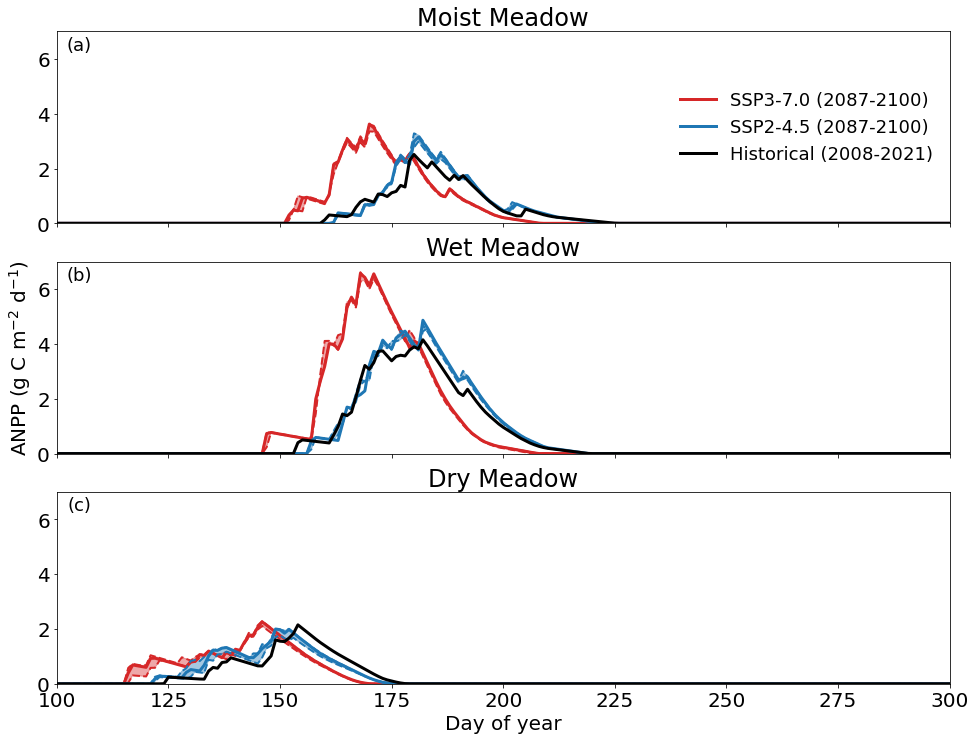

In [31]:
veglist = ['Moist Meadow','Wet Meadow','Dry Meadow']

x1 = ds1.AGNPP.sel(sim='Saddle').groupby("time.dayofyear").mean('time')
x2 = ds1.AGNPP.sel(sim='Expt1').groupby("time.dayofyear").mean('time')
x3 = ds1.AGNPP.sel(sim='Expt2').groupby("time.dayofyear").mean('time')
x4 = ds3.AGNPP.sel(sim='control').groupby("time.dayofyear").mean('time')
x5 = ds3.AGNPP.sel(sim='acquis').groupby("time.dayofyear").mean('time')
x6 = ds3.AGNPP.sel(sim='cons').groupby("time.dayofyear").mean('time')

x7 = dsSad.AGNPP.groupby("time.dayofyear").mean('time')

fig, axs = plt.subplots(3, 1,  gridspec_kw={'wspace': 0.3, 'hspace': 0.2}, figsize=(16,12))

for i in range(len(ds1.column)):
    y1 =  x1.isel(column=i)
    y2 =  x2.isel(column=i)
    y3 =  x3.isel(column=i) 
    y4 =  x4.isel(column=i)
    y5 =  x5.isel(column=i)
    y6 =  x6.isel(column=i)
    y7 =  x7.isel(column=i)

    axs[i].plot(x1['dayofyear'], y1, label='SSP3-7.0 (2087-2100)', linewidth=3, color='tab:red') ;
    axs[i].plot(x2['dayofyear'], y2, '--', linewidth=2, color='tab:red') ;
    axs[i].plot(x3['dayofyear'], y3, '--', linewidth=2, color='tab:red') ;
    axs[i].fill_between(x1['dayofyear'], y1 + (y2-y1), y1 - (y1-y3), alpha=0.4, color='tab:red')
    
    axs[i].plot(x4['dayofyear'], y4, label='SSP2-4.5 (2087-2100)', linewidth=3, color='tab:blue') ;
    axs[i].plot(x2['dayofyear'], y5, '--', linewidth=2, color='tab:blue') ;
    axs[i].plot(x3['dayofyear'], y6, '--', linewidth=2, color='tab:blue') ;
    axs[i].fill_between(x4['dayofyear'], y4 + (y5-y4), y4 - (y4-y6), alpha=0.4, color='tab:blue')
    
    axs[i].plot(x7['dayofyear'], y7, label='Historical (2008-2021)', linewidth=3, color='k') ;
    
    axs[i].set_title(veglist[i])
    axs[i].set_ylim([0, 7])
    axs[i].set_xlim([100, 300])
     
    axs[i].annotate(panel[i], xy=(105, 6.5), ha='center', va='center',fontsize=18)

    if i==0:
        axs[i].legend(frameon=False,fontsize=18,loc='center right')
        
    if i==1:
        axs[i].set_ylabel('ANPP (g C $\mathregular{m^{-2}}$ $\mathregular{d^{-1}}$)') 
        
    if i==2:
        axs[i].set_xlabel('Day of year') 
    else:
        axs[i].axes.xaxis.set_ticklabels([])    

#plt.savefig(out_dir+'FigS1.pdf');

#### Comparing snow depth between trait experiments for historical and future scenarios (Figure S2)

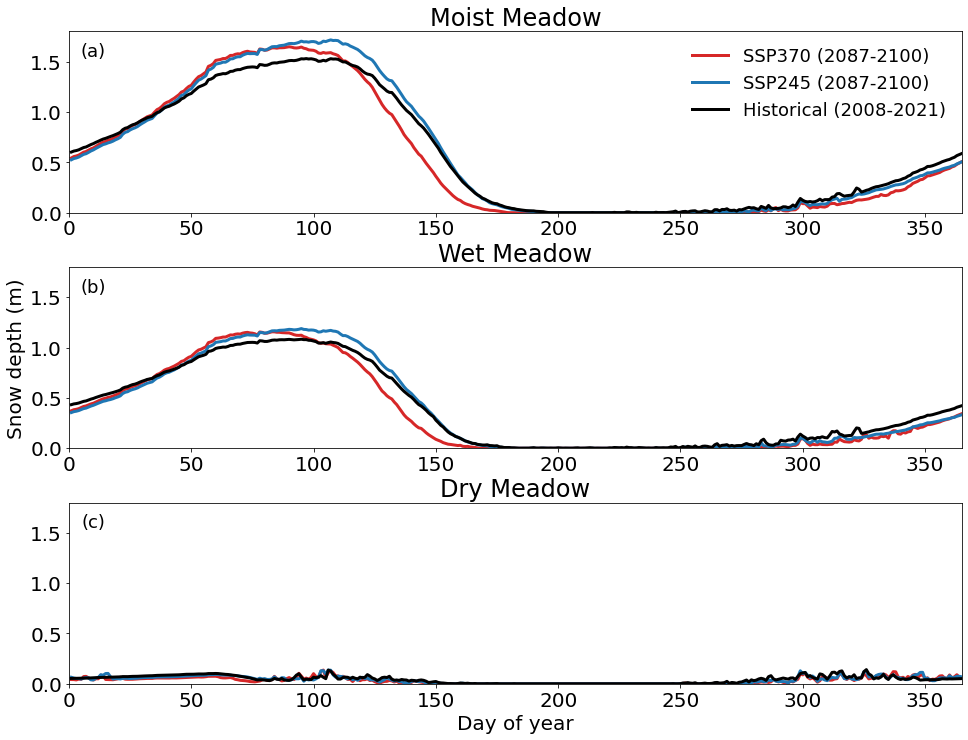

In [41]:
# make a snow figure to pair with GPP
veglist = ['Moist Meadow','Wet Meadow','Dry Meadow']

x1 = ds1.SNOW_DEPTH.sel(sim='Saddle').groupby("time.dayofyear").mean('time')
x2 = ds3.SNOW_DEPTH.sel(sim='control').groupby("time.dayofyear").mean('time')
x3 = dsSad.SNOW_DEPTH.groupby("time.dayofyear").mean('time')

fig, axs = plt.subplots(3, 1,  gridspec_kw={'wspace': 0.3, 'hspace': 0.3}, figsize=(16,12))

for i in range(len(ds1.column)):
    y1 =  x1.isel(column=i)
    y2 =  x2.isel(column=i)
    y3 =  x3.isel(column=i) 

    axs[i].plot(x1['dayofyear'], y1, label='SSP370 (2087-2100)', linewidth=3, color='tab:red') ;    
    axs[i].plot(x2['dayofyear'], y2, label='SSP245 (2087-2100)', linewidth=3, color='tab:blue') ;
    axs[i].plot(x3['dayofyear'], y3, label='Historical (2008-2021)', linewidth=3, color='k') ;
    
    axs[i].set_title(veglist[i])
    axs[i].set_ylim([0, 1.8])
    axs[i].set_xlim([0, 365])
    axs[i].annotate(panel[i], xy=(10, 1.6), 
            ha='center', va='center',fontsize=18)  
     
    if i==0:
        axs[i].legend(frameon=False,fontsize=18)
        
    if i==1:
        axs[i].set_ylabel('Snow depth (m)',fontsize=20) 
        
    if i==2:
        axs[i].set_xlabel('Day of year',fontsize=20) 
    
#plt.savefig(out_dir+'FigS2.pdf');